In [1]:
%matplotlib inline
import itertools
from decimal import Decimal

import market
from simulate import simulate_withdrawals
from harvesting import N_60_RebalanceHarvesting, N_100_RebalanceHarvesting
import harvesting
import withdrawal
import math
import plot
import pandas
import metrics

def p(d):
    return "${:,}".format(int(d))

PORTFOLIO = (600000, 400000)
YEAR = 1972

/Users/justus/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


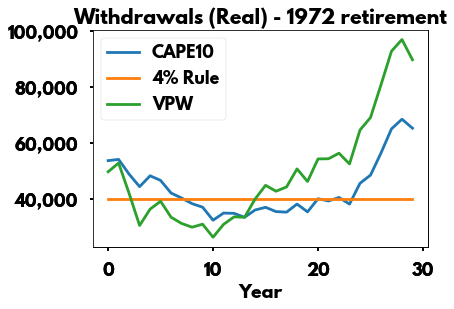

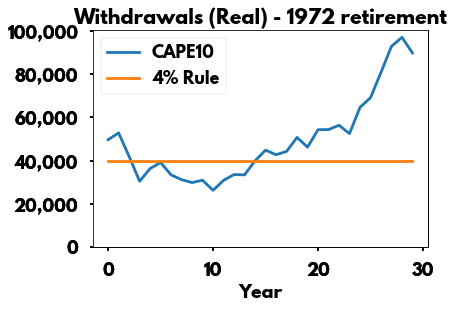

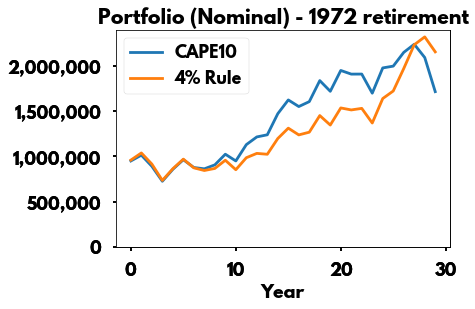

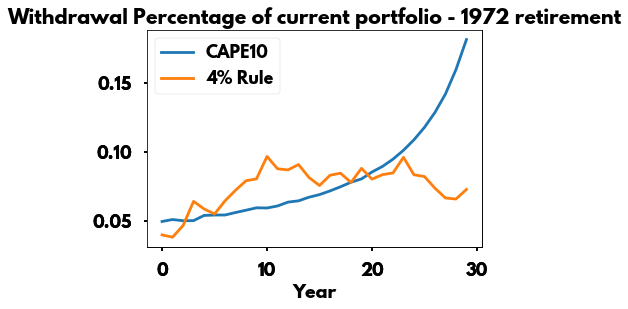

In [3]:
def compare(series, years=40):
    (r1, r2, r3) = itertools.tee(series, 3)
    
    TYPE = 'CAPE10'

    constant = simulate_withdrawals(r1, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('0.04')), portfolio=PORTFOLIO)
    vpw = simulate_withdrawals(r2, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.VPW(p, h), portfolio=PORTFOLIO)
    #vpw = simulate_withdrawals(r2, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.Clyatt(p, h), portfolio=PORTFOLIO)
    smooth = simulate_withdrawals(r3, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.CAPE10Smoothing(1972, withdrawal.VPW(p, h)), portfolio=PORTFOLIO)

    plot.plot_n({'4% Rule': [n.withdraw_r for n in constant], 'VPW': [n.withdraw_r for n in vpw], 'CAPE10': [n.withdraw_r for n in smooth]}, 'Year', 'Withdrawals (Real) - %s retirement' % YEAR, zero_based=False)
    
    plot.plot_n({'4% Rule': [n.withdraw_r for n in constant], TYPE: [n.withdraw_r for n in vpw]}, 'Year', 'Withdrawals (Real) - %s retirement' % YEAR, zero_based=True)
    plot.plot_n({'4% Rule': [n.portfolio_n for n in constant], TYPE: [n.portfolio_n for n in vpw]}, 'Year', 'Portfolio (Nominal) - %s retirement' % YEAR)
    plot.plot_n({'4% Rule': [n.withdraw_pct_cur for n in constant], TYPE: [n.withdraw_pct_cur for n in vpw]}, 'Year', 'Withdrawal Percentage of current portfolio - %s retirement' % YEAR, zero_based=False, add_commas=False)

compare(market.Returns_US_1871().iter_from(YEAR), years=30)

In [4]:
def compare(series, years=40):
    (r1, r2, r3) = itertools.tee(series, 3)

    x = simulate_withdrawals(r1, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('0.04')), portfolio=PORTFOLIO)
    y = simulate_withdrawals(r2, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.VPW(p, h), portfolio=PORTFOLIO)
    z = simulate_withdrawals(r3, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.CAPE10Smoothing(1972, withdrawal.VPW(p, h)), portfolio=PORTFOLIO)

    s1 = [n.withdraw_r for n in x]
    s2 = [n.withdraw_r for n in y]
    s3 = [n.withdraw_r for n in z]
    
    print(YEAR, 'CEW', 'VPW:', p(metrics.cew(s2)), 'Smooth:', p(metrics.cew(s3)))
#    print('Total$', 'VPW:', p(sum(s2)), 'Smooth:', p(sum(s3)))
#    print('10th', 'VPW:', p(pandas.Series([float(s) for s in s2]).quantile(.1)), 'Smooth:', p(pandas.Series([float(s) for s in s3]).quantile(.1)))
#    df = pandas.DataFrame(y)
#    df.index = pandas.Series(range(1972, 1972+years))
    
#    plot.plot_n({'4% Rule': s1, 'VPW': s2, '1/CAPE VPW' : s3}, 'Year', '%s Retirement' % YEAR)

compare(market.Returns_US_1871().iter_from(YEAR), years=30)

1972 CEW VPW: $38,290 Smooth: $40,044


In [5]:
def make_cews(series, start_year, years):
    (r2, r3) = itertools.tee(series, 2)

    y = simulate_withdrawals(r2, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.VPW(p, h, years_left=45), portfolio=PORTFOLIO)
    z = simulate_withdrawals(r3, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.CAPE10Smoothing(start_year, withdrawal.VPW(p, h, years_left=45)), portfolio=PORTFOLIO)

    s2 = [n.withdraw_r for n in y]
    s3 = [n.withdraw_r for n in z]

    return (metrics.cew(s2), metrics.cew(s3))

cews = {}

for year in range(1881, 1986):
    plain, smooth = make_cews(market.Returns_US_1871().iter_from(year), year, 30)
    cews[year] = (plain, smooth)

In [6]:
plain, smooth = [dict(zip(cews, col)) for col in zip(*cews.values())]

/Users/justus/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


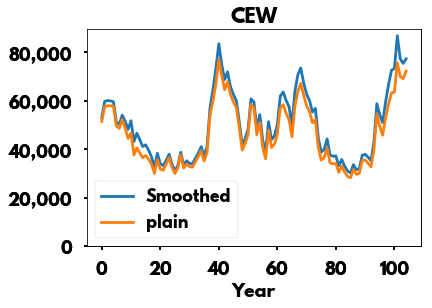

In [7]:
plot.plot_n({'plain': plain.values(), 'Smoothed': smooth.values()}, 'Year', 'CEW')